# FBI Gun Data

The data comes from the FBI's National Instant Criminal Background Check System. The NICS is used by to determine whether a prospective buyer is eligible to buy firearms or explosives. Gun shops call into this system to ensure that each customer does not have a criminal record or isn’t otherwise ineligible to make a purchase. The data has been supplemented with state level data from census.gov.

The NICS data is found in one sheet of an .xlsx file. It contains the number of firearm checks by month, state, and type.
The U.S. census data is found in a .csv file. It contains several variables at the state level. Most variables just have one data point per state (2016), but a few have data for more than one year.
<ol>
    <li>What census data is most associated with high gun per capita?</li>
    <li>Which states have had the highest growth in gun registrations?</li> 
    <li>What is the overall trend of gun purchases?</li>
</ol>
Loading data:

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#%pylab inline
%matplotlib inline

gun_data = pd.read_csv('gun_data.csv')
US_Census_Data = pd.read_csv('US_Census_Data.csv')

In [166]:
gun_data.head(2)#check the data reading

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303


In [88]:
gun_data.shape#check the data scale

(12485, 27)

In [167]:
US_Census_Data.head(2)#check the data reading

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"


In [67]:
US_Census_Data.shape#check the data scale

(85, 52)

## Data refine and state grouping
To start analysis, we need to refine data. Define
<ul>
    <li>prepawn</li>
    <li>redemption</li>
    <li>returned</li>
    <li>rentals</li>
    <li>private_sale</li>
    <li>return_to_Seller</li>
</ul>
By sum over corresponding handgun, long_gun, and other column.

In [165]:
#By state grouping data
state_vs_gun = gun_data.groupby(['state'], as_index = False).sum()
state_vs_gun.head(2)

,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,Alabama,1047441.0,749.0,2222037.0,2626029.0,39578.0,105230,32.0,4239.0,6343.0,...,0.0,1.0,0.0,224.0,207.0,19.0,14.0,12.0,6.0,6706079
1,Alaska,13352.0,22.0,434602.0,572174.0,15970.0,28904,19.0,1043.0,1463.0,...,14.0,0.0,0.0,196.0,245.0,10.0,3.0,6.0,1.0,1137643


We find there are no rentals_other column. We add it for convenient. 

In [163]:
state_vs_gun['rentals_other'] = 0

In [164]:
#Create new columes
def sum_over_guns(gun_dataframe,column_index):
    '''
    '''
    handgun = column_index + '_handgun'
    long_gun = column_index + '_long_gun'
    other = column_index + '_other'
    sum_over_guns = gun_dataframe[handgun] + gun_dataframe[long_gun] + gun_dataframe[other]
    return sum_over_guns

state_vs_gun['prepawn'] = sum_over_guns(state_vs_gun,'prepawn')
state_vs_gun['redemption'] = sum_over_guns(state_vs_gun,'redemption')
state_vs_gun['returned'] = sum_over_guns(state_vs_gun,'returned')
state_vs_gun['rentals'] = sum_over_guns(state_vs_gun,'rentals')
state_vs_gun['private_sale'] = sum_over_guns(state_vs_gun,'private_sale')
state_vs_gun['return_to_seller'] = sum_over_guns(state_vs_gun,'return_to_seller')

state_vs_gun.head(2)

,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,...,return_to_seller_long_gun,return_to_seller_other,totals,prepawn,redemption,returned,private_sale,return_to_seller,rentals_other,rentals
0,Alabama,1047441.0,749.0,2222037.0,2626029.0,39578.0,105230,32.0,4239.0,6343.0,...,12.0,6.0,6706079,10608.0,653892.0,0.0,450.0,32.0,0,1.0
1,Alaska,13352.0,22.0,434602.0,572174.0,15970.0,28904,19.0,1043.0,1463.0,...,6.0,1.0,1137643,2507.0,68682.0,950.0,451.0,10.0,0,0.0


## State v.s handgun and long gun
Check the distribution of gun v.s state. We may find which state got most of guns.

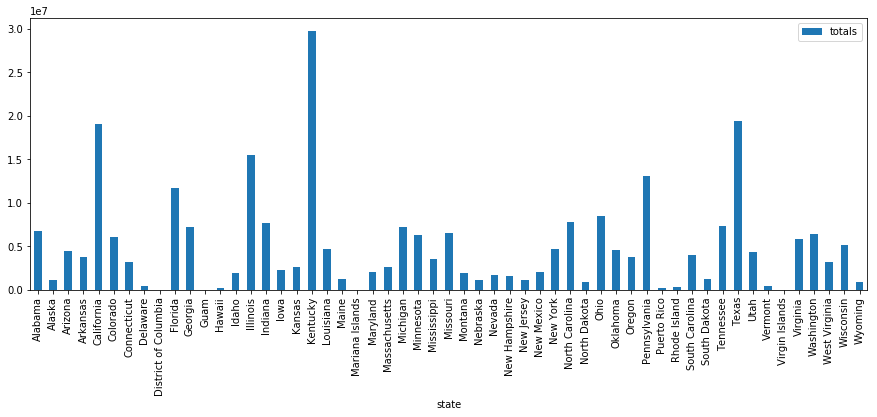

In [150]:
key_index = ['state', 'totals']
state_vs_gun_total = state_vs_gun.loc[:,key_index]
state_vs_gun_total.plot(x='state',kind='bar', figsize=(15,5))
#maybe we can modify y axis

In [111]:
state = state_vs_gun['state']

## Which states have had the highest growth in gun registrations?

In [118]:
#Find top 5 state has more handgun.
handgun_sort = state_vs_gun.sort_values('handgun',ascending=False)
top_5_handgun_state = handgun_sort.iloc[0:5,0]
top_5_handgun_state

46         Texas
4     California
9        Florida
37          Ohio
45     Tennessee
Name: state, dtype: object

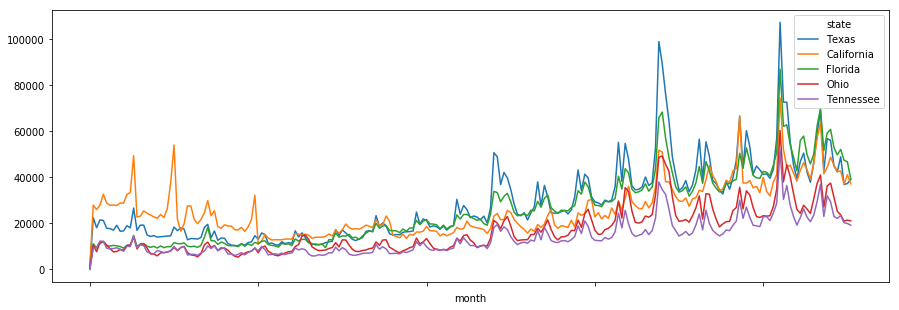

In [119]:
time_vs_handgun = gun_data.groupby(['month','state'], as_index = False)['handgun'].sum()
time_vs_handgun_reshape = time_vs_handgun.pivot(index='month', columns='state', values='handgun')
time_vs_handgun_reshape.loc[:,top_5_handgun_state].plot(kind='line',sort_columns = True, figsize=(15,5))

In [120]:
#Find top 5 state has more long gun.
long_gun_sort = state_vs_gun.sort_values('long_gun',ascending=False)
top_5_long_gun_state = long_gun_sort.iloc[0:5,0]
top_5_long_gun_state

40    Pennsylvania
46           Texas
4       California
9          Florida
37            Ohio
Name: state, dtype: object

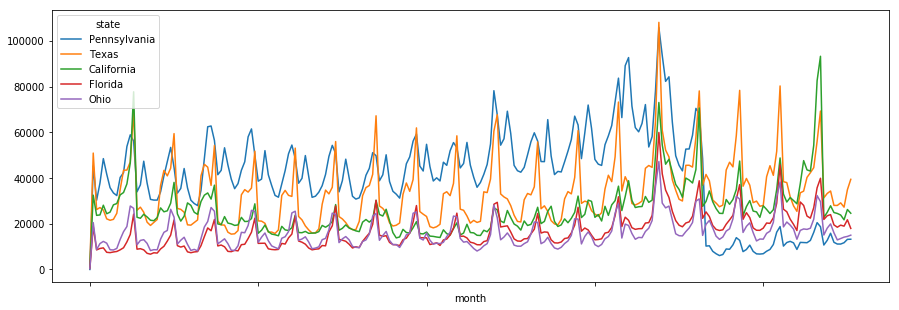

In [121]:
time_vs_long_gun = gun_data.groupby(['month','state'], as_index = False)['long_gun'].sum()
time_vs_long_gun_reshape = time_vs_long_gun.pivot(index='month', columns='state', values='long_gun')
time_vs_long_gun_reshape.loc[:,top_5_long_gun_state].plot(kind='line',sort_columns = True, figsize=(15,5))

In [122]:
totals_sort = state_vs_gun.sort_values('totals',ascending=False)
top_5_total_gun_state = totals_sort.iloc[0:5,0]
top_5_total_gun_state

18        Kentucky
46           Texas
4       California
14        Illinois
40    Pennsylvania
Name: state, dtype: object

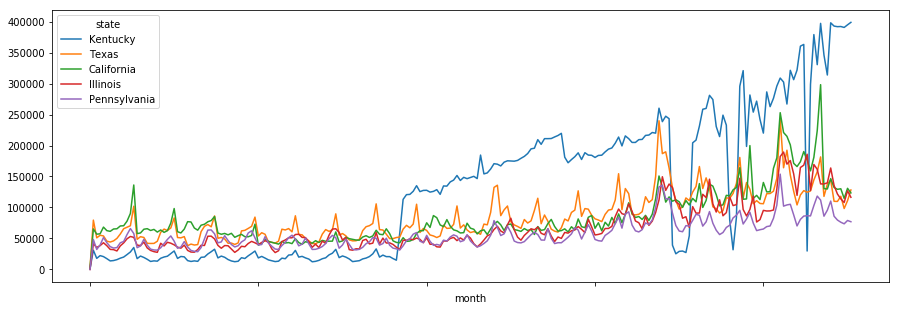

In [126]:
time_vs_total_gun = gun_data.groupby(['month','state'], as_index = False)['totals'].sum()
time_vs_total_gun_reshape = time_vs_total_gun.pivot(index='month', columns='state', values='totals')
time_vs_total_gun_reshape.loc[:,top_5_total_gun_state].plot(kind='line',sort_columns = True, figsize=(15,5))

## What census data is most associated with high gun per capita?


## What is the overall trend of gun purchases?